In [1]:
import numpy as np
from dLdp import analytic_dLdp,dLdp
from matplotlib import pyplot as plt
from matplotlib import style
from functools import partial

In [2]:
def plot_trajectories(q_traj,p_trajs,n_p):
    style.use('fivethirtyeight')
    p_trajs=p_trajs.reshape(-1,n_p,2)
    plt.plot(q_traj[0,:],q_traj[1,:],'*',label="Target")
    for i in range(n_p):
        plt.plot(p_trajs[:,i,0],p_trajs[:,i,1],'.',label="Mobile Sensor {}".format(i))
    plt.legend()
    plt.show()


In [3]:
sigma=1.
C0s=np.array([0.,0.,0.])
C1s=np.array([0.1,0.1,0.1])
ks=np.array([1.5,0.5,1.])
bs=np.array([-2,-2,-2])

q=np.array([0.,0.])
ps=np.array([[1.,0],[0,1.],[-1,0.0]])


In [4]:
q_traj=q[...,np.newaxis]
p_trajs=ps[...,np.newaxis]

# Path Planning with constant step size. That is $||\alpha_i \nabla_{p_i}L||=constant$

# With n_timestep <=100, the path planing is very fast.

In [5]:
from regions import Rect2D
def polar_projection(q,ps,r):    
    """ 
        Return the projection of a set of points ps onto a circle centered at q with radius r
    """
    q=q.reshape(-1,2)
    ps=ps.reshape(-1,2)
    dists=np.linalg.norm(ps-q,axis=1)

    dists[dists==0]=1 # Handling the zero distances
    ps_proj=((ps-q).T/dists * r).T +q
    return ps_proj

def FIM_ascent_path_planning(f_dLdp,q,ps,n_p,n_timesteps,max_linear_speed,dt,epsilon,region=None):
    """
        f_dLdp: a function handle, f_dLdp(q,ps)=dLdp.
        q: Current location of the target.
        ps: Current locations of the mobile sensors.
        n_p: The number of sensors
        n_timesteps: The number of timesteps to plan ahead. 
        
            The total time horizon T will be T=n_timesteps*dt.
        
        max_linear_speed: the linear speed limit to be set on the mobile sensors.
        dt: the time differences between two consecutive waypoints.
        
            The update step size will be a constant = max_linear_speed * dt
        
        epsilon: when the planned trajectories end, how far away should they be to the target.
        region: If None, unconstraint gradient ascent is performed. Otherwise, region should be
        of class Region as defined in regions.py file in fim_track package, and projected gradient 
        ascent onto the given region will be performed.
        ----------------------------------------------------------------------------------------
        Output: waypoints for each mobile sensor, Shape= (num_time_steps,num_sensors,2)
    """

    step_size=max_linear_speed*dt
    p_trajs=[]
    
    q=q.reshape(-1,2)
    ps=ps.reshape(-1,2)
    
    for i in range(n_timesteps):
        # Calculate the gradient
        grad=f_dLdp(q,ps)
        grad=grad.reshape(-1,2)
        grad_sizes=np.linalg.norm(grad,axis=1)
        # print(ps,q)
        # print("grad_sizes",grad_sizes)

        grad_sizes[grad_sizes==0]=1 # Handle the case where the partial derivative is zero.

        update_steps=(grad.T/grad_sizes * step_size).T # Calculate the update steps to be applied to ps
# 
        candid_ps=ps+update_steps # Calculate the direct update 
        
        if not region is None:
            for i in range(len(ps)):
                proj=region.project_point(candid_ps[i,:])
                if not proj is None:
                    candid_ps[i,:]=proj
                    
        # Project candid_ps onto the "surveillance circle" once it steps into it
        if not np.all(np.linalg.norm(candid_ps-q,axis=1)>=epsilon):
            insiders=np.linalg.norm(candid_ps-q,axis=1)<epsilon
            ps=candid_ps
            ps[insiders]=polar_projection(q,candid_ps,epsilon)[insiders] # Update ps.
            p_trajs.append(ps)
            break # Exit the loop once some mobile sensor's trajectory reaches the circle.
        else:
            ps=candid_ps # Update ps.
            p_trajs.append(ps)
    return np.array(p_trajs).reshape(-1,n_p,2) # Shape= (num_time_steps,num_sensors,2)

In [8]:
from functools import partial
region = Rect2D((0,4),(0,4))
max_linear_speed=1.22
dt=0.1
epsilon=0.1
sigma=1.
C0s=np.array([0.,0.,0.])
C1s=np.array([0.1,0.1,0.1])
ks=np.array([1.5,0.5,1.])
bs=np.array([-2.,-2.,-2.])

q=np.array([5.,5.])
ps=np.array([[1.,0],[0,1.],[-1,0.0]])
n_p=len(ps)
n_timesteps=100

# f_dLdp=partial(analytic_dLdp,sigma=sigma,C1s=C1s,C0s=C0s,ks=ks,bs=bs)

f_dLdp=dLdp(C1s=C1s,C0s=C0s,ks=ks,bs=bs)

# Unconstraint Gradient Ascent

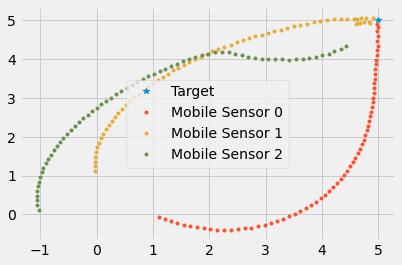

In [10]:

p_trajs=FIM_ascent_path_planning(f_dLdp,q,ps,n_p,n_timesteps,max_linear_speed,dt,epsilon,region=None)

q_traj=q[...,np.newaxis]

plot_trajectories(q_traj,p_trajs,n_p)

# Projected Gradient Ascent onto Rect2D((0,4),(0,4))

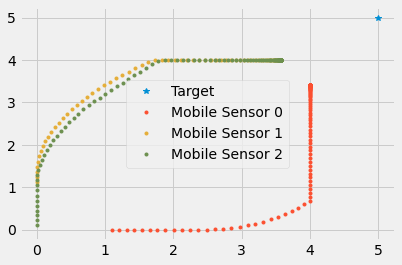

In [9]:

p_trajs=FIM_ascent_path_planning(f_dLdp,q,ps,n_p,n_timesteps,max_linear_speed,dt,epsilon,region=region)

q_traj=q[...,np.newaxis]

plot_trajectories(q_traj,p_trajs,n_p)